In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
import sklearn.metrics as metrics
import numpy as np
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
import nltk
from nltk import pos_tag 
import os,re, unicodedata
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import wordnet 
!pip install tqdm
from tqdm.notebook import tqdm
from tqdm import tqdm, tqdm_notebook

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("/kaggle/input/fake-news-data-for-classification/fake-news-data.csv")
print(df.shape)
df.head()

(51233, 3)


,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


#### Cleaning Data

In [3]:
df=df.replace(to_replace ="FAKE", value =0) 
df=df.replace(to_replace ="REAL", value =1) 

In [4]:
df.dropna()
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(51233, 3)


,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [5]:
df["merged"]=df["title"] + " " + df["text"]
df.head()

,title,text,label,merged
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0,You Can Smell Hillary’s Fear Daniel Greenfield...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0,Watch The Exact Moment Paul Ryan Committed Pol...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1,Kerry to go to Paris in gesture of sympathy U....
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0,Bernie supporters on Twitter erupt in anger ag...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1,The Battle of New York: Why This Primary Matte...


In [6]:
# Stopword list
pattern = re.compile(r'\b('+r'|'.join(stopwords.words('english'))+r')\b\s*')

# @cuda.jit(device=True)
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# @tf.function()
def clean_text(text):
    text = unicode_to_ascii(str(text).lower().strip())
    
    # creating a space between a word and the punctuation following it
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    
    # replacing all the stopwords
    text = pattern.sub('',text)
    
    # removes all the punctuations
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    
    text = text.strip()
    
    return text

clean_text_vect = np.vectorize(clean_text)


In [7]:
def chunk_clean(array,chunk_size=64):
    cleaned_array = []
    
    for i in tqdm(range(0, len(array), chunk_size)):
        text_chunk = clean_text_vect(array[i:i+chunk_size])
        cleaned_array.extend(text_chunk)

    return np.array(cleaned_array)

In [8]:
lema=wordnet.WordNetLemmatizer()

def text_normalization(text): 
    tokens=nltk.word_tokenize(text)     
    tags_list=pos_tag(tokens,tagset=None) 

    lema_words=[] 
    for token,pos_token in tags_list:
        if pos_token.startswith('V'):  # Verb
            pos_val='v'
        elif pos_token.startswith('J'): # Adjective
            pos_val='a'
        elif pos_token.startswith('R'): # Adverb
            pos_val='r'
        else:
            pos_val='n' # Noun
            
        lema_token=lema.lemmatize(token,pos_val) 
        lema_words.append(lema_token) 
    
    return " ".join(lema_words)

text_norm_vect = np.vectorize(text_normalization)

In [9]:
def chunk_text_normalize(array,chunk_size=64):
    norm_array = []
    
    for i in tqdm(range(0, len(array), chunk_size)):
        text_chunk = text_norm_vect(array[i:i+chunk_size])
        norm_array.extend(text_chunk)
    
    return np.array(norm_array)    

In [10]:
def truncate(text):
    text = text.split()
    text = text[0:170]
    
    return ' '.join(text)

In [11]:
df['truncated_text'] = df['merged'].apply(truncate)
df.head()

,title,text,label,merged,truncated_text
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0,You Can Smell Hillary’s Fear Daniel Greenfield...,You Can Smell Hillary’s Fear Daniel Greenfield...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0,Watch The Exact Moment Paul Ryan Committed Pol...,Watch The Exact Moment Paul Ryan Committed Pol...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1,Kerry to go to Paris in gesture of sympathy U....,Kerry to go to Paris in gesture of sympathy U....
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0,Bernie supporters on Twitter erupt in anger ag...,Bernie supporters on Twitter erupt in anger ag...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1,The Battle of New York: Why This Primary Matte...,The Battle of New York: Why This Primary Matte...


In [12]:
# # df['cleaned_data'] = chunk_clean(df.merged.values)

# cleaned_data = chunk_clean(df.merged.values)
# norm_data = chunk_text_normalize(cleaned_data)

df['cleaned_data'] = df['truncated_text'].apply(clean_text)
df['norm_data'] = df['cleaned_data'].apply(text_normalization)
df.head()

,title,text,label,merged,truncated_text,cleaned_data,norm_data
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0,You Can Smell Hillary’s Fear Daniel Greenfield...,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary fear daniel greenfield shillman ...,smell hillary fear daniel greenfield shillman ...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0,Watch The Exact Moment Paul Ryan Committed Pol...,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan committed politic...,watch exact moment paul ryan commit political ...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1,Kerry to go to Paris in gesture of sympathy U....,Kerry to go to Paris in gesture of sympathy U....,kerry go paris gesture sympathy u secretary st...,kerry go paris gesture sympathy u secretary st...
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0,Bernie supporters on Twitter erupt in anger ag...,Bernie supporters on Twitter erupt in anger ag...,bernie supporters twitter erupt anger dnc trie...,bernie supporter twitter erupt anger dnc try w...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1,The Battle of New York: Why This Primary Matte...,The Battle of New York: Why This Primary Matte...,battle new york primary matters primary day ne...,battle new york primary matter primary day new...


#### Splitting Data

In [13]:
x_train,x_test,y_train,y_test=train_test_split(df['cleaned_data'], df['label'], test_size=0.025, random_state=1)

#### TFIDF-Vectorizer

In [14]:
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7, use_idf=True)
tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)

In [15]:
tfidf_vectorizer.get_feature_names()

['00',
 '000',
 '0000',
 '0001',
 '0005',
 '0009',
 '000ecuador',
 '000ft',
 '000km',
 '000m',
 '000s',
 '001',
 '0018',
 '0019',
 '0020',
 '003',
 '0036',
 '0040',
 '0041',
 '0045',
 '0047',
 '004s',
 '005',
 '0050',
 '005930',
 '005s',
 '006',
 '00684',
 '006s',
 '007',
 '007s',
 '008',
 '008s',
 '009',
 '00am',
 '00pm',
 '01',
 '010',
 '0100',
 '011',
 '0111',
 '0112',
 '0129',
 '0130',
 '014',
 '0149',
 '015760',
 '01am',
 '02',
 '020',
 '0200',
 '02046',
 '0207',
 '0211',
 '022',
 '0221',
 '0225',
 '0232',
 '0235',
 '025',
 '0259',
 '025comoros',
 '026',
 '027',
 '028',
 '02pm',
 '02welcome',
 '03',
 '0300',
 '0307',
 '031',
 '0311',
 '032',
 '033',
 '0330',
 '034',
 '0340',
 '0342',
 '035',
 '038',
 '039',
 '03eb',
 '04',
 '040',
 '0400',
 '042',
 '042660',
 '043',
 '0430',
 '044',
 '0440',
 '0443utc',
 '046',
 '04am',
 '04vidc5g7t',
 '05',
 '050',
 '0500',
 '050albania',
 '051',
 '0513',
 '0515',
 '052',
 '053',
 '0530',
 '0539',
 '0548',
 '055',
 '056',
 '057',
 '058',
 '059',


#### Passive Aggressive Classifier

In [16]:
pac=PassiveAggressiveClassifier(early_stopping=True,validation_fraction=.025,verbose=1,shuffle=True,random_state=1)
pac.fit(tfidf_train,y_train)
y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

-- Epoch 1
Norm: 76.73, NNZs: 46575, Bias: -0.629985, T: 48703, Avg. loss: 0.149857
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 94.11, NNZs: 48032, Bias: -0.613514, T: 97406, Avg. loss: 0.063365
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 105.73, NNZs: 48595, Bias: -0.620455, T: 146109, Avg. loss: 0.040846
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 114.01, NNZs: 48882, Bias: -0.708226, T: 194812, Avg. loss: 0.028169
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 120.30, NNZs: 49057, Bias: -0.669894, T: 243515, Avg. loss: 0.020382
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 124.87, NNZs: 49123, Bias: -0.725451, T: 292218, Avg. loss: 0.014781
Total training time: 0.17 seconds.
Convergence after 6 epochs took 0.18 seconds
Accuracy: 97.42%


#### Confusion Matrix

In [17]:
def plot_confusion_matrix(cm, classes,normalize=False,cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.cmap=cmap
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

accuracy:   0.974
Confusion matrix, without normalization


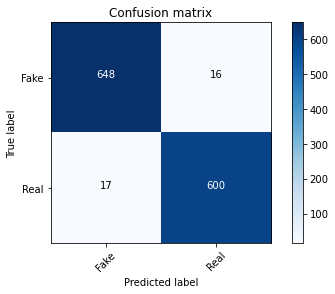

In [18]:
pred = pac.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=[0,1])
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

**Normalized Data**

In [19]:
x_train1,x_test1,y_train1,y_test1=train_test_split(df['norm_data'], df['label'], test_size=0.025, random_state=1)
tfidf_vectorizer1=TfidfVectorizer(stop_words='english', max_df=0.7, use_idf=True)
tfidf_train1=tfidf_vectorizer.fit_transform(x_train1) 
tfidf_test1=tfidf_vectorizer.transform(x_test1)
pac1=PassiveAggressiveClassifier(early_stopping=True,validation_fraction=.025,verbose=1,shuffle=True,random_state=1)
pac1.fit(tfidf_train1,y_train1)
y_pred1=pac1.predict(tfidf_test1)
score1=accuracy_score(y_test1,y_pred1)
print(f'Accuracy: {round(score1*100,2)}%')


-- Epoch 1
Norm: 74.98, NNZs: 39225, Bias: -0.688848, T: 48703, Avg. loss: 0.151709
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 92.85, NNZs: 40797, Bias: -0.693425, T: 97406, Avg. loss: 0.071354
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 105.41, NNZs: 41355, Bias: -0.693008, T: 146109, Avg. loss: 0.049771
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 114.95, NNZs: 41637, Bias: -0.798127, T: 194812, Avg. loss: 0.036894
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 122.59, NNZs: 41785, Bias: -0.742799, T: 243515, Avg. loss: 0.028503
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 128.55, NNZs: 41875, Bias: -0.803102, T: 292218, Avg. loss: 0.022311
Total training time: 0.17 seconds.
Convergence after 6 epochs took 0.18 seconds
Accuracy: 96.57%


accuracy:   0.966
Confusion matrix, without normalization


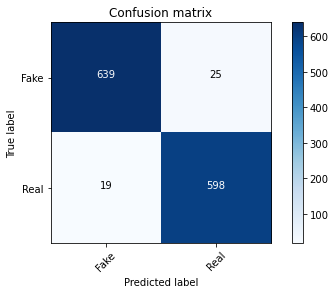

In [20]:
pred1 = pac1.predict(tfidf_test1)
score1 = metrics.accuracy_score(y_test1, pred1)
print("accuracy:   %0.3f" % score1)
cm = metrics.confusion_matrix(y_test1, pred1, labels=[0,1])
plot_confusion_matrix(cm, classes=['Fake', 'Real'])